In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pretrain-coco-weights-pytorch/deeplabv3_resnet50_coco-cd0a2569.pth
/kaggle/input/pretrain-coco-weights-pytorch/fcn_resnet50_coco-1167a1af.pth
/kaggle/input/pretrain-coco-weights-pytorch/deeplabv3_resnet101_coco-586e9e4e.pth
/kaggle/input/pretrain-coco-weights-pytorch/fcn_resnet101_coco-7ecb50ca.pth
/kaggle/input/hubmap-kidney-segmentation/sample_submission.csv
/kaggle/input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv
/kaggle/input/hubmap-kidney-segmentation/train.csv
/kaggle/input/hubmap-kidney-segmentation/test/afa5e8098.tiff
/kaggle/input/hubmap-kidney-segmentation/test/b9a3865fc-anatomical-structure.json
/kaggle/input/hubmap-kidney-segmentation/test/b9a3865fc.tiff
/kaggle/input/hubmap-kidney-segmentation/test/afa5e8098-anatomical-structure.json
/kaggle/input/hubmap-kidney-segmentation/test/c68fe75ea.tiff
/kaggle/input/hubmap-kidney-segmentation/test/26dc41664-anatomical-structure.json
/kaggle/input/hubmap-kidney-segmentation/test/c68fe75ea-anatomical-s

In [2]:
!pip install pretrainedmodels
!pip install segmentation_models_pytorch
!pip install efficientnet_pytorch

     |████████████████████████████████| 58 kB 870 kB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=e8ec1d01040a93d6c8c3cd20df6c846d19ee0ea33a2e24507d70f4c968d9b849
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 66 kB 826 kB/s 
     |████████████████████████████████| 244 kB 4.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=3cc2af4a21c0bd4dfbce659aa16f0bb6162bf5555d0f941eee161df5cc41398c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade p

In [3]:
# import segmentation_models_pytorch as smp
# model=smp.Unet(
#         encoder_name='efficientnet-b5',
#         encoder_weights='imagenet',
#         decoder_attention_type='scse',
#         in_channels= 3,
#         classes= 1)
# #    加上ASPP结构
# model.decoder.center=ASPP(512,512)
# # for name,i in model.decoder.named_children():
# #     print(name)

# import torch
# inputs=torch.zeros((1,3,256,256))
# output=model.encoder(inputs)
# print(output[0].shape)


In [4]:
import pretrainedmodels
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [5]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b5')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


In [6]:
import torch
inputs=torch.zeros((1,3,256,256))
outputs=model.extract_features(inputs)
outputs.shape

torch.Size([1, 2048, 8, 8])

In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
import glob
import tifffile
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
import albumentations as A
import rasterio
from rasterio.windows import Window

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

def set_seeds(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
set_seeds()

In [8]:
DATA_PATH = '../input/hubmap-kidney-segmentation/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(DEVICE)

import logging

logging.basicConfig(filename='log.log',
                    format='%(asctime)s - %(name)s - %(levelname)s -%(module)s:  %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S ',
                    level=logging.INFO)

cuda


In [9]:
data_information=pd.read_csv('../input/hubmap-kidney-segmentation/train.csv',
                               index_col=[0])
print(data_information.index.values[:5])
data_information.head()

['2f6ecfcdf' 'aaa6a05cc' 'cb2d976f4' '0486052bb' 'e79de561c']


,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...


In [10]:
# used for converting the decoded image to rle mask
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

In [11]:
class HubDataset(D.Dataset):

    def __init__(self, path, tiff_ids, transform,
                 window=256, overlap=32, threshold = 100, isvalid=False):
        self.path = pathlib.Path(path)
        self.tiff_ids = tiff_ids
        #切分一张tiff时，生成的多张图片中的重合度
        self.overlap = overlap
        self.window = window
        self.transform = transform
        #取tiff文件的名字
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
        #是否生成验证集
        self.isvalid = isvalid
        
        self.x, self.y, self.id = [], [], []
        self.build_slices()
        self.len = len(self.x)
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        
    
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        #遍历每一张图片
        for i, filename in enumerate(self.csv.index.values):
            #csv中的tiff文件在train数据中不存在
            if not filename in self.tiff_ids:
                continue
            
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            
            # print('Transform', filename)
            #打开一个栅格化的文件
            with rasterio.open(filepath, transform = identity) as dataset:
                #对一个tiff的标签数据进行解码成mask图片
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset.shape))
                #对一个tiff图片进行切分，返回的是切分的坐标列表
                slices = make_grid(dataset.shape, window=self.window, min_overlap=self.overlap)
                
                for slc in slices:
                    x1,x2,y1,y2 = slc
                    # print(slc)
                    #根据坐标对一个tiff进行切分
                    image = dataset.read([1,2,3],
                            window=Window.from_slices((x1,x2),(y1,y2)))
                    #通道转换(3,256,256)-》(256,256，3)
                    image = np.moveaxis(image, 0, -1)

                    image = cv2.resize(image, (256, 256))
                    #根据坐标也对一个masks进行切分
                    masks = cv2.resize(self.masks[-1][x1:x2,y1:y2], (256, 256))
                    
                    if self.isvalid:
                        #如果生成验证集，把切分的坐标记下，文件id名也记下
                        self.slices.append([i,x1,x2,y1,y2])
                        self.x.append(image)
                        self.y.append(masks)
                        self.id.append(filename)
                    else:
                        #如果生成训练集，就对训练集中mask像素值sum大于阈值的进行筛选
                        #像素值mean大于阈值的操作是为了增加一些标签白色处较少的标签数据
                        #efficientnet-b5-ASSP-(image>32).mean() > 0.50-loss_fn_ratio=0.8  score0.848 
                        if self.masks[-1][x1:x2,y1:y2].sum() >= self.threshold or (image>32).mean() > 0.50:
                            self.slices.append([i,x1,x2,y1,y2])
                            self.x.append(image)
                            self.y.append(masks)
                            self.id.append(filename)
    
    # get data operation
    def __getitem__(self, index):
        image, mask = self.x[index], self.y[index]
        #数据增强
        augments = self.transform(image=image, mask=mask)
        return self.as_tensor(augments['image']), augments['mask'][None]
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        self.len = len(self.x)
        return self.len

In [12]:
import functools
import torch.utils.model_zoo as model_zoo
from torchvision.models.resnet import ResNet
from torchvision.models.resnet import BasicBlock
from torchvision.models.resnet import Bottleneck
#导入torchvision_models中各种模型的参数设置，可以用于设置torchvision中的模型
from pretrainedmodels.models.torchvision_models import pretrained_settings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [13]:
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                     stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class ASPP(nn.Module):
    def __init__(self, inplanes=512, mid_c=256, dilations=[1, 6, 12, 18,24]):
        super(ASPP, self).__init__()
        self.aspp1 = _ASPPModule(inplanes, mid_c, 1, padding=0, dilation=dilations[0])
        self.aspp2 = _ASPPModule(inplanes, mid_c, 3, padding=dilations[1], dilation=dilations[1])
        self.aspp3 = _ASPPModule(inplanes, mid_c, 3, padding=dilations[2], dilation=dilations[2])
        self.aspp4 = _ASPPModule(inplanes, mid_c, 3, padding=dilations[3], dilation=dilations[3])
        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, mid_c, 1, stride=1, bias=False),
                                             nn.BatchNorm2d(mid_c),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(mid_c * 5, mid_c, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_c)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4,x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


In [14]:
def train(model, train_loader, criterion, optimizer):
    losses = []
    for i, (image, target) in enumerate(train_loader):
        #target为mask的图片（258,256,1）
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        #梯度归零
        optimizer.zero_grad()
        
        output = model(image)
        #计算损失
        loss = criterion(output, target, 0.2, False)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
#         print('train, ', loss.item())
    return np.array(losses).mean()

def np_dice_score(probability, mask,threshold=0.5):
    p = probability.reshape(-1)
    t = mask.reshape(-1)

    p = p>threshold
    t = t>threshold
    uion = p.sum() + t.sum()
    
    overlap = (p*t).sum()
    dice = 2*overlap/(uion+0.001)
    return dice

def validation(model, val_loader, criterion,threshold=0.5):
    val_probability, val_mask = [], []
    model.eval()
    with torch.no_grad():
        for image, target in val_loader:
            image, target = image.to(DEVICE), target.float().to(DEVICE)
            output = model(image)
            
            output_ny = output.sigmoid().data.cpu().numpy()
            target_np = target.data.cpu().numpy()
            
            val_probability.append(output_ny)
            val_mask.append(target_np)
            
    val_probability = np.concatenate(val_probability)
    val_mask = np.concatenate(val_mask)
    
    return np_dice_score(val_probability, val_mask,threshold=threshold)

In [15]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

class Lovasz_Binary_Losses(nn.Module):
    def __init__(self, per_image=True, ignore=None):
        super(Lovasz_Binary_Losses, self).__init__()
        self.per_image = per_image
        self.ignore = ignore
    
    def forward(self, x, y):
        
        return self.lovasz_hinge(x,y,self.per_image,self.ignore)
        
    def lovasz_grad(self,gt_sorted):
        """
        Computes gradient of the Lovasz extension w.r.t sorted errors
        See Alg. 1 in paper
        """
        p = len(gt_sorted)
        gts = gt_sorted.sum()
        intersection = gts - gt_sorted.float().cumsum(0)
        union = gts + (1 - gt_sorted).float().cumsum(0)
        jaccard = 1. - intersection / union
        if p > 1: # cover 1-pixel case
            jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
        return jaccard
    # --------------------------- BINARY LOSSES ---------------------------
    def lovasz_hinge(self,logits, labels, per_image=True, ignore=None):
        """
        Binary Lovasz hinge loss
          logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
          labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
          per_image: compute the loss per image instead of per batch
          ignore: void class id
        """
        if per_image:
            loss_list=torch.tensor([self.lovasz_hinge_flat(*self.flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                              for log, lab in zip(logits, labels)])
            loss = torch.mean(loss_list)
        else:
            loss = self.lovasz_hinge_flat(*self.flatten_binary_scores(logits, labels, ignore))
        return loss

    def lovasz_hinge_flat(self,logits, labels):
        """
        Binary Lovasz hinge loss
          logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
          labels: [P] Tensor, binary ground truth labels (0 or 1)
          ignore: label to ignore
        """
        if len(labels) == 0:
            # only void pixels, the gradients should be 0
            return logits.sum() * 0.
        signs = 2. * labels.float() - 1.
        errors = (1. - logits * Variable(signs))
        errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
        perm = perm.data
        gt_sorted = labels[perm]
        grad = self.lovasz_grad(gt_sorted)
        loss = torch.dot(F.relu(errors_sorted), Variable(grad))
        return loss

    def flatten_binary_scores(self,scores, labels, ignore=None):
        """
        Flattens predictions in the batch (binary case)
        Remove labels equal to 'ignore'
        """
        scores = scores.view(-1)
        labels = labels.view(-1)
        if ignore is None:
            return scores, labels
        valid = (labels != ignore)
        vscores = scores[valid]
        vlabels = labels[valid]
        return vscores, vlabels



class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        
        return 1 - dc

bce_fn = nn.BCEWithLogitsLoss()
Lovasz_fn=Lovasz_Binary_Losses()
dice_fn = SoftDiceLoss()
    
def loss_fn(y_pred, y_true, ratio=1, hard=False):
    bce = bce_fn(y_pred, y_true)
#     lovasz=Lovasz_fn(y_pred, y_true)
    lovasz=(Lovasz_fn(y_pred, y_true) + Lovasz_fn(-y_pred, 1 - y_true)) / 2
    if hard:
        dice = dice_fn((y_pred.sigmoid()).float() > 0.5, y_true)
    else:
        dice = dice_fn(y_pred.sigmoid(), y_true)
    return ratio*bce + (1-ratio)*lovasz

In [16]:
EPOCHES = 15
BATCH_SIZE = 8

WINDOW=1024
MIN_OVERLAP=40
NEW_SIZE=256

train_trfm = A.Compose([
    A.Resize(NEW_SIZE, NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.GaussNoise(),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=25, val_shift_limit=25, p=0.5),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
#     A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.RandomContrast(),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),   
        A.RandomGamma(),
        A.RandomBrightness(),
        A.ColorJitter(brightness=0.07, contrast=0.07,
                   saturation=0.1, hue=0.1, always_apply=False, p=0.3),
        ], p=0.3),
])

val_trfm = A.Compose([
    A.Resize(NEW_SIZE,NEW_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])

# 每个file单独做一个验证集
tiff_ids = np.array([x.split('/')[-1][:-5] for x in glob.glob('../input/hubmap-kidney-segmentation/train/*.tiff')])
skf = KFold(n_splits=8)

In [17]:
%%time
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(tiff_ids, tiff_ids)):
    print(tiff_ids[val_idx])
    print("加载数据中")
    # break
    train_ds = HubDataset(DATA_PATH, tiff_ids, window=WINDOW, overlap=MIN_OVERLAP, 
                          threshold=100, transform=train_trfm, isvalid=False)
    valid_ds = HubDataset(DATA_PATH, tiff_ids[val_idx], window=WINDOW, overlap=MIN_OVERLAP, 
                          threshold=100, transform=val_trfm, isvalid=True)

    print(len(train_ds), len(valid_ds))
    print("定义training和validation的dataloader")
    # define training and validation data loaders
    train_loader = D.DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=12,drop_last=True)

    val_loader = D.DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=12,drop_last=True)
    print("定义模型中...")
    #resnet50-score0.824     #se_resnet50-score0.815  #efficientnet-b5-score0.848
    import segmentation_models_pytorch as smp
    model=smp.Unet(
        encoder_name='efficientnet-b5',
        encoder_weights='imagenet',
#         decoder_attention_type='scse',
        in_channels= 3,
        classes= 1)
#    加上ASPP结构
    model.decoder.center=ASPP(512,512)
    
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#     lr_step = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 2)
    lr_step = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
    
    print("开始训练")
    header = r'''
            Train | Valid
    Epoch |  Loss |  Dice (Best) | Time
    '''
    print(header)
    #          Epoch         metrics            time
    raw_line = '{:6d}' + '\u2502{:7.4f}'*3 + '\u2502{:6.2f}'
    
    best_dice = 0
    
    for epoch in range(1, EPOCHES+1):
        start_time = time.time()
        model.train()
        train_loss = train(model, train_loader, loss_fn, optimizer)
        val_dice = validation(model, val_loader, loss_fn,0.5)
        lr_step.step(val_dice)
        
        if val_dice > best_dice:
            best_dice = val_dice
            i=5
            torch.save(model.state_dict(), './fold_{}.pth'.format(i))
            print("best_savefold_{}.pth ".format(fold_idx))
        print("epoch:",epoch, "train_loss:",train_loss, "val_dice:",val_dice ,"best_dice:",best_dice)

        
    
    del train_loader, val_loader, train_ds, valid_ds
    gc.collect()
    break
    

['095bf7a1f']
加载数据中
6324 1560
定义training和validation的dataloader
定义模型中...
开始训练

            Train | Valid
    Epoch |  Loss |  Dice (Best) | Time
    
best_savefold_0.pth 
epoch: 1 train_loss: 0.31218383210925593 val_dice: 0.8450332498554345 best_dice: 0.8450332498554345
best_savefold_0.pth 
epoch: 2 train_loss: 0.21745244597708896 val_dice: 0.8541396200208021 best_dice: 0.8541396200208021
best_savefold_0.pth 
epoch: 3 train_loss: 0.1974938310650354 val_dice: 0.8643081240144666 best_dice: 0.8643081240144666
epoch: 4 train_loss: 0.190226041903289 val_dice: 0.8491368903578506 best_dice: 0.8643081240144666
best_savefold_0.pth 
epoch: 5 train_loss: 0.16415569658225948 val_dice: 0.874287969397852 best_dice: 0.874287969397852
epoch: 6 train_loss: 0.16010863586136248 val_dice: 0.8717586814123004 best_dice: 0.874287969397852
epoch: 7 train_loss: 0.15995323518526894 val_dice: 0.8645893235694059 best_dice: 0.874287969397852
best_savefold_0.pth 
epoch: 8 train_loss: 0.1512955832473749 val_dice: 0.8

In [18]:
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(tiff_ids, tiff_ids)):
    valid_ds = HubDataset(DATA_PATH, tiff_ids[val_idx], window=WINDOW, overlap=MIN_OVERLAP, 
                          threshold=100, transform=val_trfm, isvalid=True)
    val_loader = D.DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=12)
    break


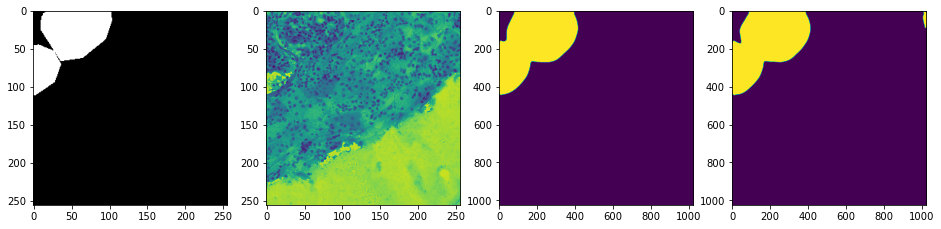

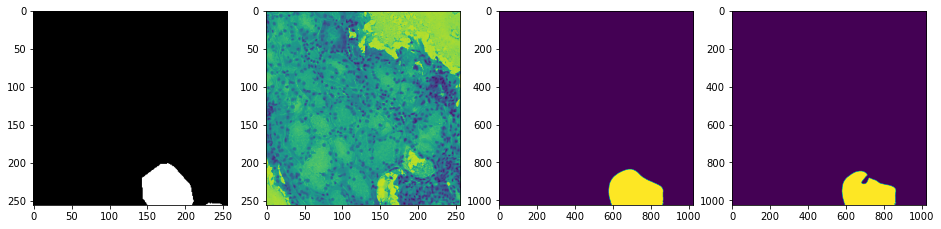

In [19]:
i=5
model.load_state_dict(torch.load("./fold_{}.pth".format(i)))    
model.eval()
c = 1
for idx in range(100, 200):
    
    image, mask = valid_ds[idx]
    if mask.max() == 0:
        continue
    
    c += 1
    if c > 10:
        continue
    
    plt.figure(figsize=(16,8))
    plt.subplot(141)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(142)
    plt.imshow(image[0]);

    with torch.no_grad():
        image = image.to(DEVICE)[None]
            
        score = model(image)[0][0]
        #反转一下让模型识别
        score2 = model(torch.flip(image, [0, 3]))
#         print(score2.shape)
        score2 = torch.flip(score2, [3, 0])[0][0]

        score3 = model(torch.flip(image, [1, 2]))
        score3 = torch.flip(score3, [2, 1])[0][0]

        #同一图片三种不同方向让模型得出三个分数取平均
        score_mean = (score + score2 + score3) / 3.0

        score_sigmoid = score_mean.sigmoid().cpu().numpy()
        score_sigmoid = cv2.resize(score_sigmoid, (WINDOW, WINDOW))

        score = score.sigmoid().cpu().numpy()
        score = cv2.resize(score, (WINDOW, WINDOW))


    plt.subplot(143)
    plt.imshow((score_sigmoid > 0.5).astype(int))

    plt.subplot(144)
    plt.imshow((score > 0.52).astype(int))

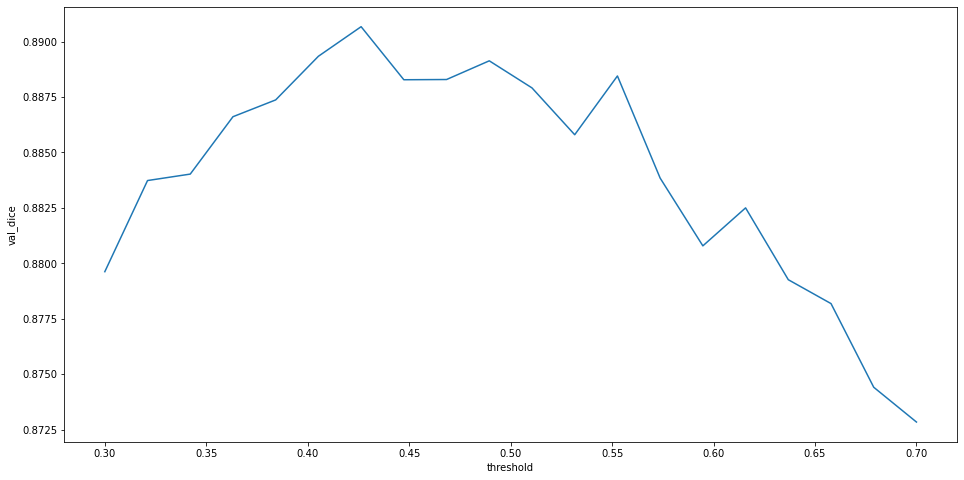

CPU times: user 4min 55s, sys: 44.9 s, total: 5min 40s
Wall time: 6min 17s


In [20]:
%%time
#卡阈值
i=5
model.load_state_dict(torch.load("./fold_{}.pth".format(i)))
import seaborn as sns
import numpy as np
val_dice_list=[]
x_list=[]
for thres in np.linspace(0.3, 0.7, num=20):
    x_list.append(thres)
    val_dice = validation(model, val_loader, loss_fn,thres)
    val_dice_list.append(val_dice)
plt.figure(figsize=(16,8))
ax = sns.lineplot(x=x_list, y=val_dice_list)
plt.xlabel("threshold")
plt.ylabel("val_dice")
plt.show()

In [21]:
best_thres=x_list[np.argmax(val_dice_list)]
best_thres

0.4263157894736842

In [22]:
%%time
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(NEW_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])


p = pathlib.Path(DATA_PATH)

subm = {}

i=5
model.load_state_dict(torch.load("./fold_{}.pth".format(i)))  
model.eval()

for i, filename in enumerate(p.glob('test/*.tiff')):
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    slices = make_grid(dataset.shape, window=WINDOW, min_overlap=MIN_OVERLAP)
    preds = np.zeros(dataset.shape, dtype=np.uint8)
    for (x1,x2,y1,y2) in slices:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
        image = trfm(image)
        with torch.no_grad():
            image = image.to(DEVICE)[None]

            score = model(image)[0][0]

            score2 = model(torch.flip(image, [0, 3]))
            score2 = torch.flip(score2, [3, 0])[0][0]

            score3 = model(torch.flip(image, [1, 2]))
            score3 = torch.flip(score3, [2, 1])[0][0]
                
            score_mean = (score + score2 + score3) / 3.0

            score_sigmoid = score_mean.sigmoid().cpu().numpy()
            score_sigmoid = cv2.resize(score_sigmoid, (WINDOW, WINDOW))
            
            preds[x1:x2,y1:y2] = (score_sigmoid > best_thres).astype(np.uint8)
            
    subm[i] = {'id':filename.stem, 'predicted': rle_numba_encode(preds)}
    del preds
    gc.collect()

CPU times: user 19min 23s, sys: 48.7 s, total: 20min 11s
Wall time: 25min 1s


In [23]:
submission = pd.DataFrame.from_dict(subm, orient='index')
submission.to_csv('submission.csv', index=False)

In [24]:
#SWA 一个epochs里的对多次训练得的权重进行平均
# from torchcontrib.optim import SWA
# base_opt=torch.optim.SGD(model.parameters(),lr=0.1)
# opt=torchcontirb.optim.SWA(base_opt,swa_start,swa_freq=5)
# for _ in range(100):
#     opt.zero_grad()
#     loss_fn(model(input),target).backward()
#     opt.step()
# opt.swap_swa_Sgd()

In [25]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
import glob
import tifffile
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tqdm.notebook import tqdm
import albumentations as A
import rasterio
from rasterio.windows import Window

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

def set_seeds(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
set_seeds()

# 数据的EDA和数据增强的筛选

In [26]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_train[df_train["id"] == image_id]["encoding"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask


def read_test_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"test/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image


def plot_image_and_mask(image, mask, image_id):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    
    w_len = image.shape[0]
    h_len = image.shape[1]
    
    min_len = min(w_len, h_len)
    w_start = (w_len - min_len) // 2
    h_start = (h_len - min_len) // 2
    
    plt.imshow(image[w_start : w_start + min_len, h_start : h_start + min_len])
    plt.imshow(
        mask[w_start : w_start + min_len, h_start : h_start + min_len], cmap="hot", alpha=0.5,
    )
    plt.axis("off")
            
    plt.show()
    

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 4, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 4, 3)
    plt.imshow(sub_mask, cmap="hot")
    plt.axis("off")
    
    import albumentations as A
    aug =    A.HueSaturationValue(hue_shift_limit=25, sat_shift_limit=25, val_shift_limit=25, p=0.5)
    image_aug = aug(image=sub_image)['image']
    plt.subplot(1, 4, 4)
    plt.imshow(image_aug)
    plt.axis("off")
    
    plt.show()

In [27]:
# BASE_PATH = "../input/hubmap-kidney-segmentation/"
# TRAIN_PATH = os.path.join(BASE_PATH, "train")
# df_train = pd.read_csv(
#     os.path.join(BASE_PATH, "train.csv")
# )
# df_info = pd.read_csv(
#     os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
# )
# print(os.listdir(BASE_PATH))

In [28]:
image_id = "0486052bb"
image, mask = read_image(image_id, 2)

NameError: name 'BASE_PATH' is not defined

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

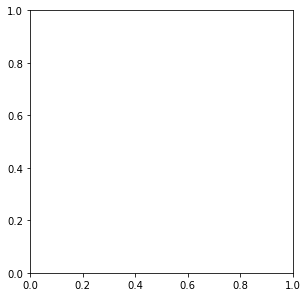

In [29]:
plot_image_and_mask(image, mask, image_id)

In [30]:
# plot_slice_image_and_mask(image, mask, 5000, 7500, 2500, 5000)
# plot_slice_image_and_mask(image, mask, 5250, 5720, 3500, 4000)
plot_slice_image_and_mask(image, mask, 5375, 5575, 3650, 3850,aug)

NameError: name 'aug' is not defined

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

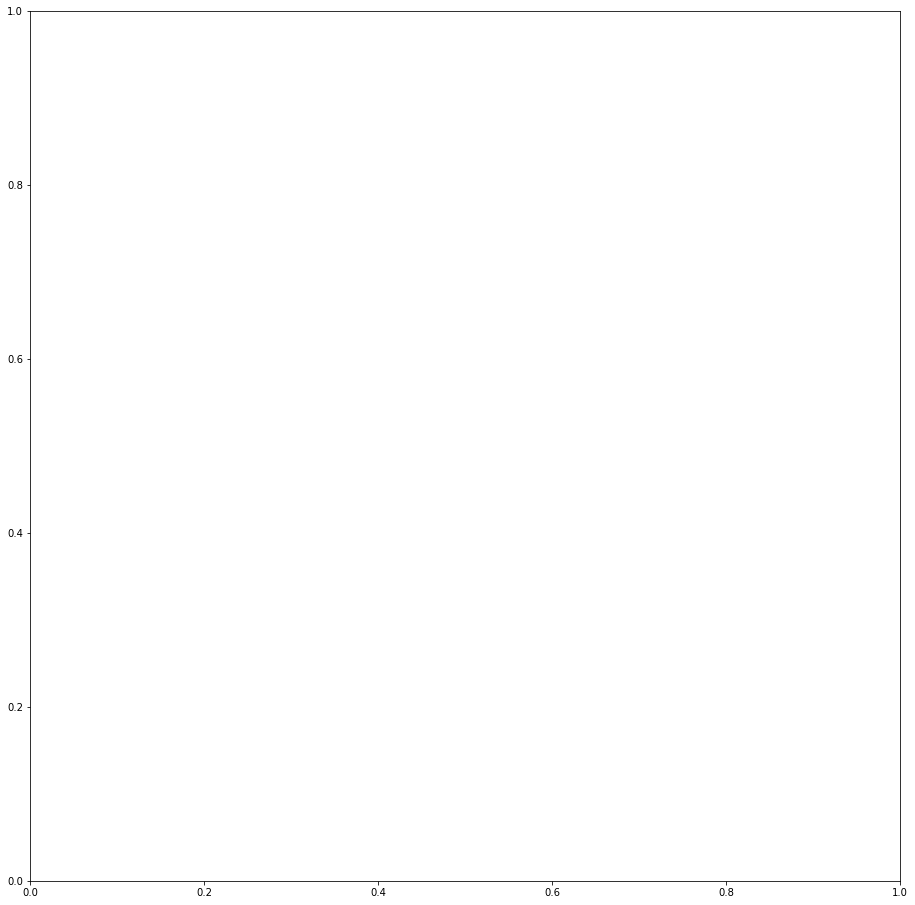

In [31]:
plot_grid_image_with_mask(image, mask)